##Goal
Goal is to train neural network to rate comments autonomously 

This is **Multilabel text classification** problem, we will be using pretrained DistilBERT from Hugingface to manage this task. In this notebook we will be using 2 models, one with Tanh antivation layer, second with Sigmoid. 

In [ ]:
! pip install transformers==3.0.2;

In [ ]:
import warnings
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
import transformers
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
import logging
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter('ignore')

Due to high resource utilization we will be using GPU.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

###Importing data:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = 'drive/MyDrive/TOXIC_COMMENTS'

#EDA

In [ ]:
train = f"{path}/train.csv"

text = 'comment_text'
target = ['toxic','severe_toxic','obscene','threat','insult', 'identity_hate']
df = pd.read_csv(train)

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Shape of data:

In [ ]:
print(f"Dataset: train\nrows: {df.shape[0]:>9}\ncolumns: {df.shape[1]}")

Dataset: train
rows:    159571
columns: 8


###Missing values:

In [ ]:
print("Missing values in Train dataset")
print(df.isnull().sum().to_string())

Missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0


There is no missing data in our dataset.

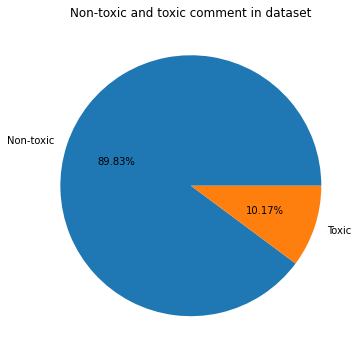

In [ ]:
plt.figure(figsize=(10,6))
plt.pie([sum(df.sum(axis=1)==0),sum(df.sum(axis=1)!=0)], labels=['Non-toxic','Toxic'], autopct='%.2f%%') 
plt.title("Non-toxic and toxic comment in dataset");

Kind of toxicity in dataset:

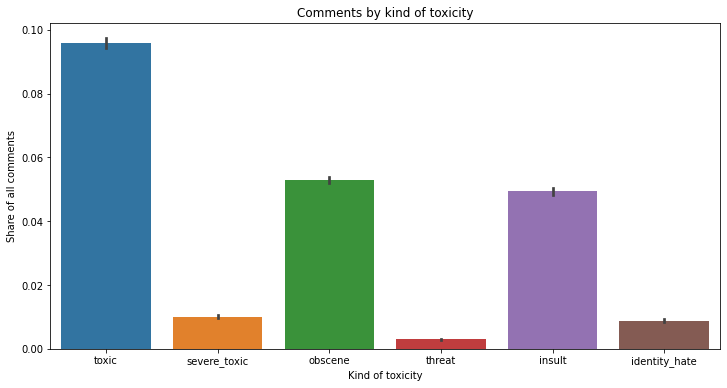

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=df).set(title='Comments by kind of toxicity')
plt.xlabel('Kind of toxicity') 
plt.ylabel('Share of all comments');

Corelation heatmap:

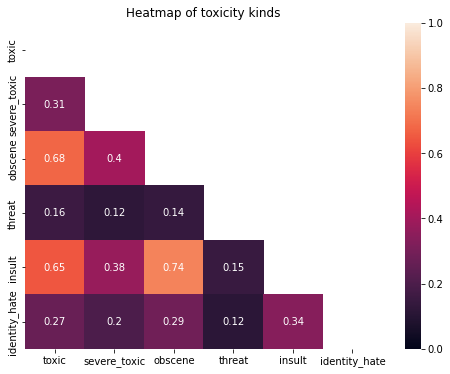

In [ ]:
corr = df[target].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, mask=np.triu(np.ones_like(corr, dtype=bool)), vmax=1, vmin=0)
plt.title('Corelation heatmap of toxicity kinds');

As we can see insult cmomments are highly correlated with toxic(0.65) and obscene(0.74). Obscene comments are also highly correlated with toxic (0.68). 

Let's check lenth of comments:

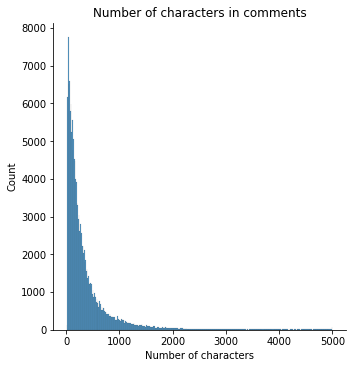

In [ ]:
sns.displot(df.comment_text.apply(lambda x: len(x)))
plt.xlabel('Number of characters') 
plt.title('Number of characters in comments');

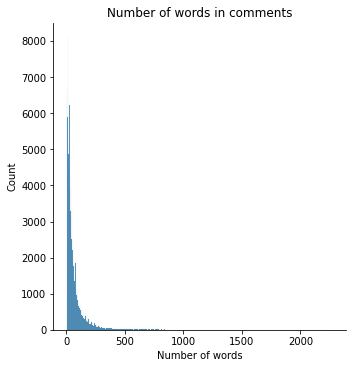

In [ ]:
sns.displot(df.comment_text.apply(lambda x: len(x.split(" "))))
plt.xlabel('Number of words') 
plt.title('Number of words in comments');

Now let's get rid of unusual characters in comments.

In [ ]:
def clean_text(txt):
    return re.sub("[^A-Za-z0-9.,;:!?]+", ' ', str(txt))

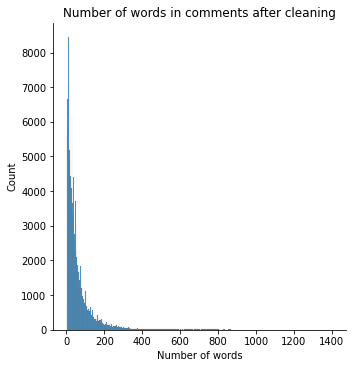

In [ ]:
sns.displot(
    df.comment_text.apply(clean_text).apply(lambda x: len(x.split(" "))))
plt.xlabel('Number of words') 
plt.title('Number of words in comments after cleaning');

In [ ]:
df.comment_text.apply(clean_text).apply(lambda x: len(x.split(" "))).describe(percentiles=[0.86])


count    159571.000000
mean         69.528160
std         102.037257
min           1.000000
50%          37.000000
86%         123.000000
max        1403.000000
Name: comment_text, dtype: float64

As we can see over 86% of comments has under 128 words due to constrained resources we will limit lenth of comments to 128.

We drop id column:

In [ ]:
df.drop(['id'], inplace=True, axis=1)

And make one-hot encode from our dataframe.

In [ ]:
df_with_vector = pd.DataFrame()
df_with_vector['text'] = df[text]
df_with_vector['vector'] = df.iloc[:, 1:].values.tolist()

In [ ]:
df_with_vector.head()

,text,vector
0,Explanation\nWhy the edits made under my usern...,"[0, 0, 0, 0, 0, 0]"
1,D'aww! He matches this background colour I'm s...,"[0, 0, 0, 0, 0, 0]"
2,"Hey man, I'm really not trying to edit war. It...","[0, 0, 0, 0, 0, 0]"
3,"""\nMore\nI can't make any real suggestions on ...","[0, 0, 0, 0, 0, 0]"
4,"You, sir, are my hero. Any chance you remember...","[0, 0, 0, 0, 0, 0]"


Here we choice `batch_size`, number of `epochs` and `learning_rate`. Due to hardware constrains we will chose `max_len` as 128. We could also enhance our model by making `max_len` variable and changing it from batch to batch. We could also go higher with `epochs` to get little bit better results.

In [ ]:
max_len = 128
batch_size = 8
epochs = 2
learning_rate = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

Class for out dataset include `special_tokens`, `max_len` and `truncation`.



In [ ]:
class MultiLabelDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.vector
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

We split dataset in 2 groups: 80% training examples and 20% of validation.

In [ ]:
train_size = 0.8
train_data, test_data = train_test_split(df_with_vector, 
                                         train_size=train_size, 
                                         random_state=42)
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
print("Dataset: {}".format(df_with_vector.shape))
print("Train Dataset: {}".format(train_data.shape))
print("Test Dataset: {}".format(test_data.shape))

training_set = MultiLabelDataset(train_data, tokenizer, max_len)
testing_set = MultiLabelDataset(test_data, tokenizer, max_len)

Dataset: (159571, 2)
Train Dataset: (127656, 2)
Test Dataset: (31915, 2)


We make dataloaders from both datasets.

In [ ]:
params = {'batch_size': batch_size,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **params)
testing_loader = DataLoader(testing_set, **params)

We will be using DestilBERT with extra Linear, Tanh, Dropout and finall Linear layer for classification. Second model will be having Sigmoid layer insted of Tanh.

In [ ]:
dropout = 0.1
out_neurons = 6

class DistilBERTClass_Tanh(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass_Tanh, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        dim = self.l1._modules['embeddings']\
        ._modules['position_embeddings'].embedding_dim
        self.pre_classifier = torch.nn.Linear(dim, dim)
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(dim, out_neurons)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_bert = self.l1(input_ids=input_ids, 
                              attention_mask=attention_mask)
        hidden_state = output_bert[0]
        out = hidden_state[:, 0]
        out = self.pre_classifier(out)
        out = torch.nn.Tanh()(out)
        out = self.dropout(out)
        output = self.classifier(out)
        return output

model_tanh = DistilBERTClass_Tanh()
model_tanh.to(device)

DistilBERTClass_Tanh(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_

In [ ]:
dropout = 0.1
out_neurons = 6

class DistilBERTClass_Sigmoid(DistilBERTClass_Tanh):
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_bert = self.l1(input_ids=input_ids, 
                              attention_mask=attention_mask)
        hidden_state = output_bert[0]
        out = hidden_state[:, 0]
        out = self.pre_classifier(out)
        out = torch.nn.Sigmoid()(out)
        out = self.dropout(out)
        output = self.classifier(out)
        return output

model_sigmoid = DistilBERTClass_Sigmoid()
model_sigmoid.to(device)

DistilBERTClass_Sigmoid(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(

For optimizer we will be using Adam because it converge quickly.

In [ ]:
optimizer_tanh = torch.optim.Adam(params = model_tanh.parameters(), lr=learning_rate)
optimizer_sigmoid = torch.optim.Adam(params = model_sigmoid.parameters(), lr=learning_rate)

### Fine Tuning 

For loss function we will be using `torch.nn.functional.binary_cross_entropy_with_logits` because it is designed to multi-label classification problems.

In [ ]:
def train(epoch,model, optimizer):
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        loss.backward()
        optimizer.step()

In [ ]:
for epoch in range(epochs):
  train(epoch, model_tanh, optimizer_tanh)

3it [00:00, 22.84it/s]

Epoch: 0, Loss:  0.6804854273796082


5006it [03:05, 28.51it/s]

Epoch: 0, Loss:  0.03380466252565384


10006it [06:09, 27.22it/s]

Epoch: 0, Loss:  0.0046075875870883465


15005it [09:16, 26.96it/s]

Epoch: 0, Loss:  0.04117945581674576


15957it [09:52, 26.91it/s]
6it [00:00, 26.78it/s]

Epoch: 1, Loss:  0.012271231040358543


5004it [03:08, 26.60it/s]

Epoch: 1, Loss:  0.01622750423848629


10005it [06:17, 27.41it/s]

Epoch: 1, Loss:  0.13326503336429596


15005it [09:25, 27.22it/s]

Epoch: 1, Loss:  0.017137132585048676


15957it [10:00, 26.56it/s]


In [ ]:
for epoch in range(epochs):
  train(epoch, model_sigmoid, optimizer_sigmoid)

5it [00:00, 24.73it/s]

Epoch: 0, Loss:  0.7121540307998657


5006it [03:08, 27.46it/s]

Epoch: 0, Loss:  0.19764244556427002


10005it [06:18, 26.35it/s]

Epoch: 0, Loss:  0.001592992222867906


15004it [09:28, 26.70it/s]

Epoch: 0, Loss:  0.04699455201625824


15957it [10:05, 26.37it/s]
3it [00:00, 23.71it/s]

Epoch: 1, Loss:  0.0007979749934747815


5004it [03:12, 25.60it/s]

Epoch: 1, Loss:  0.0007459178450517356


10003it [06:19, 26.61it/s]

Epoch: 1, Loss:  0.047471269965171814


15003it [09:28, 24.95it/s]

Epoch: 1, Loss:  0.10829087346792221


15957it [10:04, 26.39it/s]


### Validation
For validation we will be using hamming score, hamming loss, weighted recall, precision and f1_score.

In [ ]:
def validation_tanh(testing_loader, model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.tanh(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

def validation_sigmoid(testing_loader, model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

We set treshold for each label equal 0.5

In [ ]:
outputs_tanh, targets = validation_sigmoid(testing_loader, model_tanh)
final_outputs_tanh = np.array(outputs_tanh) >=0.5

3990it [01:15, 52.72it/s]


In [ ]:
outputs_sigmoid, targets = validation_tanh(testing_loader, model_sigmoid)
final_outputs_sigmoid = np.array(outputs_sigmoid) >=0.5

3990it [01:15, 52.99it/s]


In [ ]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [ ]:
val_hamming_loss = sklearn.metrics.hamming_loss(targets, final_outputs_tanh)
val_hamming_score = hamming_score(np.array(targets), np.array(final_outputs_tanh))
precision = sklearn.metrics.precision_score(y_true=targets, y_pred=final_outputs_tanh, average='weighted')
recall = sklearn.metrics.recall_score(y_true=targets, y_pred=final_outputs_tanh, average='weighted')
f1 = sklearn.metrics.f1_score(y_true=targets, y_pred=final_outputs_tanh, average='weighted')

print("Tanh activation layer:\n")
print(f"Hamming Score = {val_hamming_score:.3f}")
print(f"Hamming Loss = {val_hamming_loss:.3f}")
print(f"Weigted Precision = {precision:.3f}")
print(f"Weigted Recall = {recall:.3f}")
print(f"Weigted f1_score = {f1:.3f}")

Tanh activation layer:

Hamming Score = 0.819
Hamming Loss = 0.069
Weigted Precision = 0.063
Weigted Recall = 0.063
Weigted f1_score = 0.063


In [ ]:
val_hamming_loss = sklearn.metrics.hamming_loss(targets, final_outputs_sigmoid)
val_hamming_score = hamming_score(np.array(targets), np.array(final_outputs_sigmoid))
precision = sklearn.metrics.precision_score(y_true=targets, y_pred=final_outputs_sigmoid, average='weighted')
recall = sklearn.metrics.recall_score(y_true=targets, y_pred=final_outputs_sigmoid, average='weighted')
f1 = sklearn.metrics.f1_score(y_true=targets, y_pred=final_outputs_sigmoid, average='weighted')

print("Sigmoid activation layer:\n")
print(f"Hamming Score = {val_hamming_score:.3f}")
print(f"Hamming Loss = {val_hamming_loss:.3f}")
print(f"Weigted Precision = {precision:.3f}")
print(f"Weigted Recall = {recall:.3f}")
print(f"Weigted f1_score = {f1:.3f}")

Sigmoid activation layer:

Hamming Score = 0.952
Hamming Loss = 0.015
Weigted Precision = 0.825
Weigted Recall = 0.752
Weigted f1_score = 0.773


Tanh confusion matrixes:

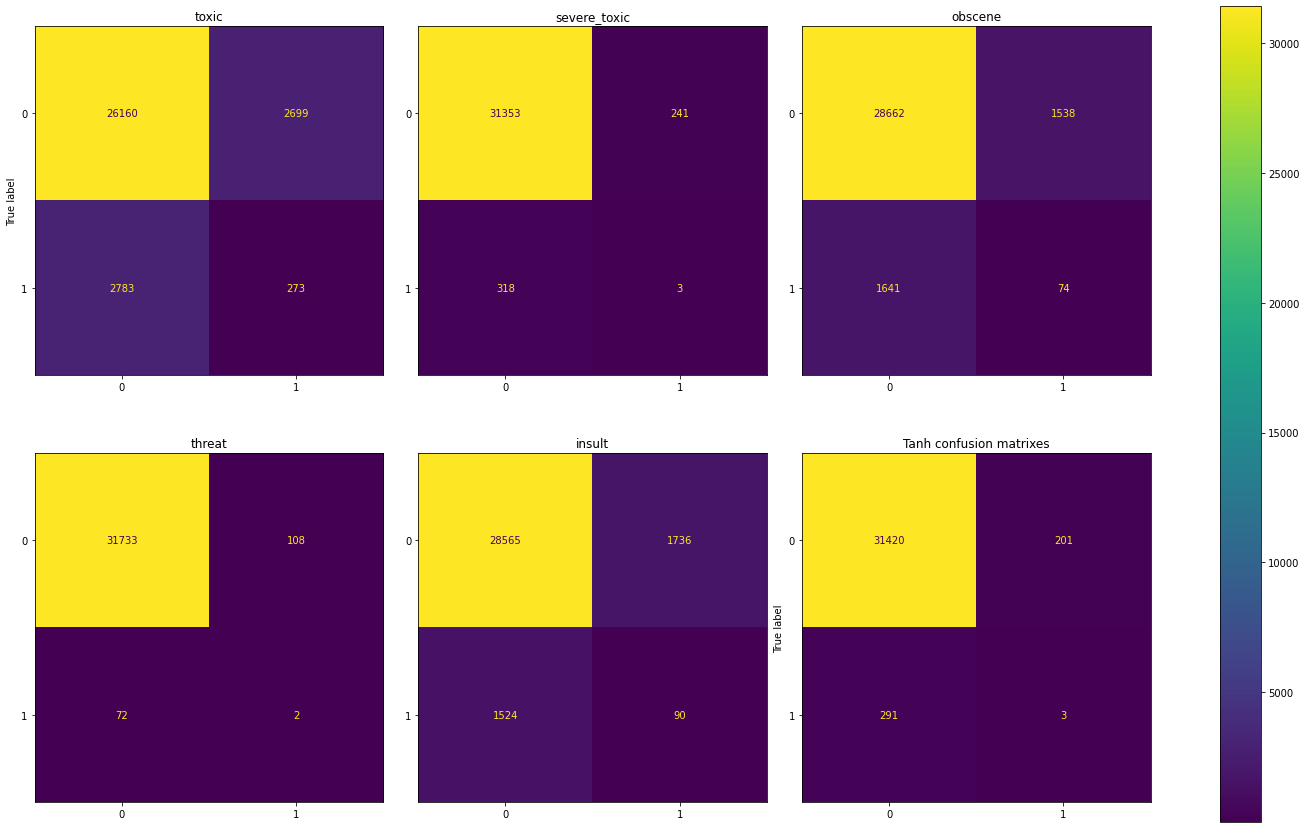

In [ ]:
matrix_tanh = multilabel_confusion_matrix(targets, final_outputs_tanh)

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for  cfs_matrix, label, i in zip(matrix_tanh, target, range(6)):
    disp = sklearn.metrics.ConfusionMatrixDisplay(cfs_matrix,
                                  display_labels=["0", "1"])
    disp.plot(ax=axes[i], values_format='d')
    disp.ax_.set_title(f'{label}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

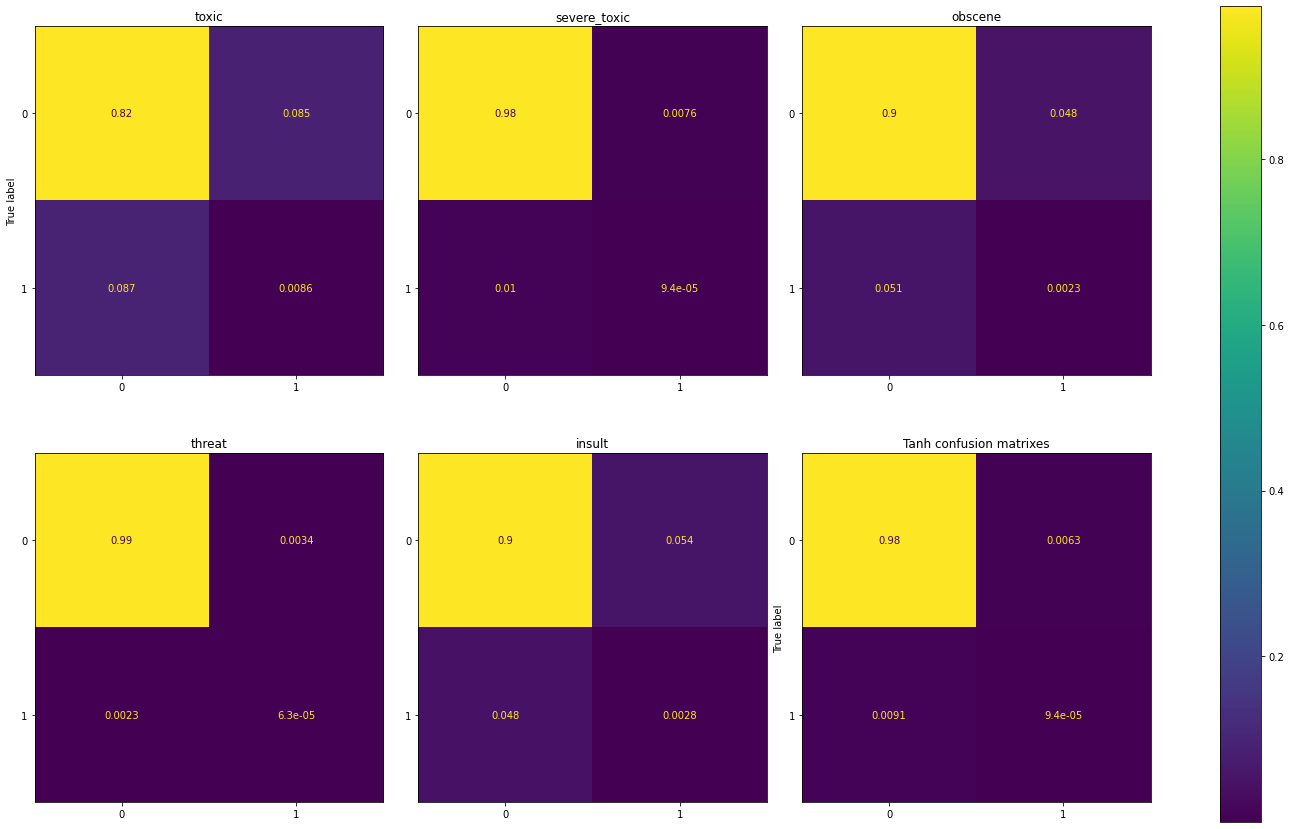

In [ ]:
matrix_sigmoid = multilabel_confusion_matrix(targets, final_outputs_sigmoid)
f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for  cfs_matrix, label, i in zip(matrix_tanh, target, range(6)):
    disp = sklearn.metrics.ConfusionMatrixDisplay(cfs_matrix/cfs_matrix.sum(),
                                  display_labels=["0", "1"])
    disp.plot(ax=axes[i], values_format='.2g')
    disp.ax_.set_title(f'{label}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

Sigmoid confusion matrixes:

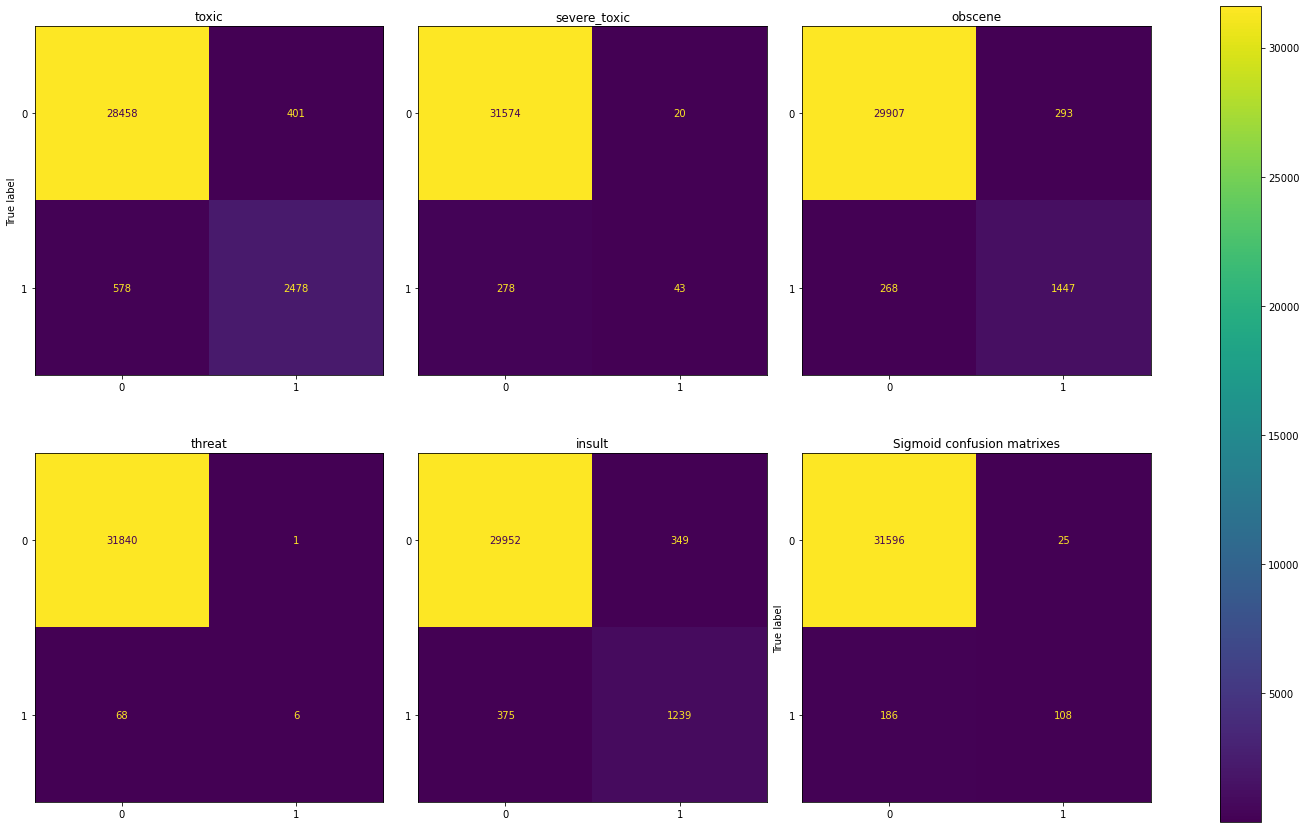

In [ ]:
matrix_sigmoid = multilabel_confusion_matrix(targets, final_outputs_sigmoid)

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for  cfs_matrix, label, i in zip(matrix_sigmoid, target, range(6)):
    disp = sklearn.metrics.ConfusionMatrixDisplay(cfs_matrix,
                                  display_labels=["0", "1"])
    disp.plot(ax=axes[i], values_format='d')
    disp.ax_.set_title(f'{label}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

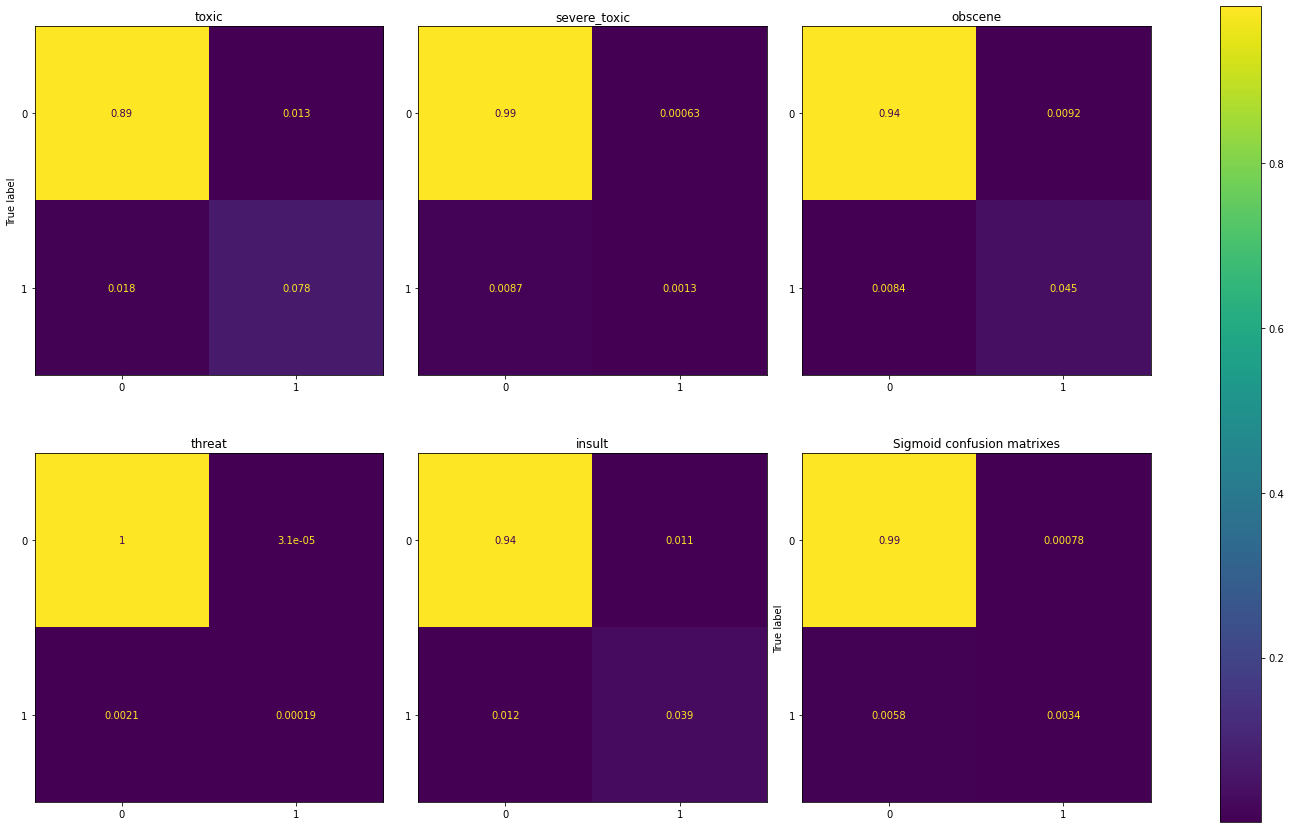

In [ ]:
f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for  cfs_matrix, label, i in zip(matrix_sigmoid, target, range(6)):
    disp = sklearn.metrics.ConfusionMatrixDisplay(cfs_matrix/cfs_matrix.sum(),
                                  display_labels=["0", "1"])
    disp.plot(ax=axes[i], values_format='.2g')
    disp.ax_.set_title(f'{label}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.title("Sigmoid confusion matrixes")
plt.show()

Conclusion:
- DestilBERT model did a great job of categorization, especially when it came to one with the singmoid activation layer model. The best results were achieved in toxic, obscene and insult, the worse results in teszcze categories are related to the small number of training examples from these categories. 

- Better results can be achieved by teaching the model for more epochs or using dynamic example length, and more new layers could also be helpful.